In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import odeint as sci_odeint
import matplotlib.patches as patches
import time
import torch.nn.functional as F

In [2]:
# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# Define the device
#device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# ==========================================
# 1. Define the Van der Pol System
# ==========================================
# System:
# dx/dt = y
# dy/dt = mu*(1-x^2)*y - x  =>  mu*y - mu*x^2*y - x
class VanDerPol:
    def __init__(self, mu=1.5): # Slightly higher mu for clearer non-linearity
        self.mu = mu

    def dynamics(self, state, t):
        x, y = state
        dxdt = y
        dydt = self.mu * (1 - x**2) * y - x
        return [dxdt, dydt]

# System: Spiral Fixed Point with non-linearity
# dx/dt = -0.1x + 2y
# dy/dt = -2x - 0.1y - 0.5x^2
def test_system(state, t):
    x, y = state
    dxdt = -0.1*x + 2.0*y
    dydt = -2.0*x - 0.1*y - 0.5*(x**2)
    return [dxdt, dydt]

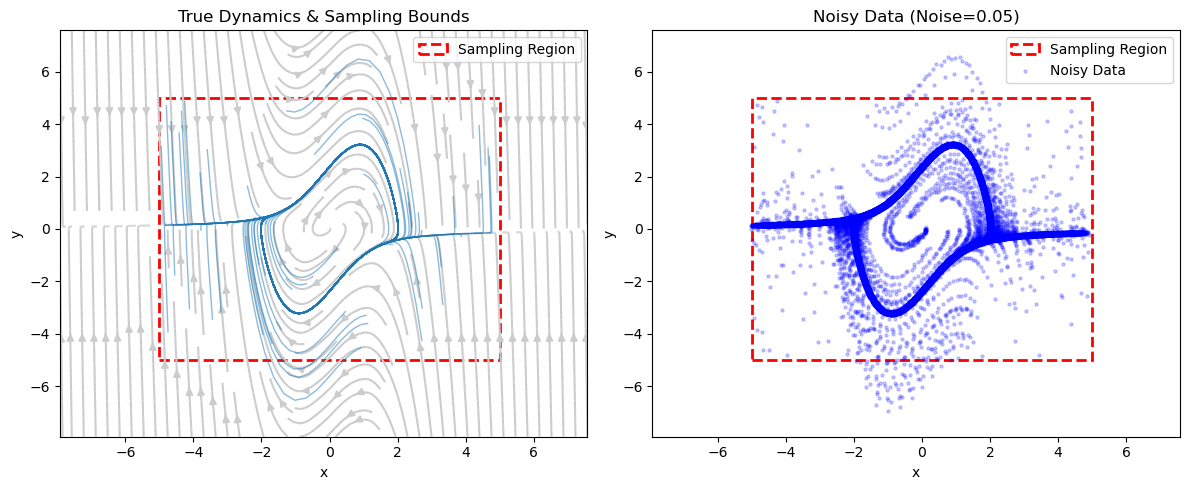

In [5]:
# ==========================================
# 2. Data Generation & Visualization
# ==========================================
def generate_random_data(func, t_span, n_trajectories, bounds, noise_level=0.0):
    # 1. Sample random initial conditions within the bounds
    x0_list = np.random.uniform(bounds[0], bounds[1], (n_trajectories, 2))
    
    data = []
    for x0 in x0_list:
        sol = sci_odeint(func, x0, t_span)
        # Add noise
        sol_noisy = sol + noise_level * np.random.randn(*sol.shape)
        data.append(sol_noisy)
    return np.array(data), x0_list

# Settings
t_max = 30.0 
dt = 0.05
t_eval = np.arange(0, t_max, dt)

n_trajectories = 200          
generation_bounds = [-5, 5]  
noise_std = 0.02

# Instantiate
vdp = VanDerPol(mu=1.5)
true_system = vdp.dynamics

# Generate
# Note: Generating "clean" data with 0 noise first is cleaner practice
clean_trajs, x0_used = generate_random_data(true_system, t_eval, n_trajectories, generation_bounds, noise_level=0.0)

# Generate noisy version
noisy_trajs = clean_trajs + noise_std * np.random.randn(*clean_trajs.shape)

# ==========================================
# Automatic Boundary Detection & Plotting
# ==========================================
# Detect Sampling Boundaries from the configuration
sample_min = generation_bounds[0]
sample_max = generation_bounds[1]
sample_width = sample_max - sample_min

# Detect View Limits (Sampling area + Trajectory excursions)
data_min = np.min(noisy_trajs)
data_max = np.max(noisy_trajs)
view_min = min(sample_min, data_min) - 1.0  # Add padding
view_max = max(sample_max, data_max) + 1.0

plt.figure(figsize=(12, 5))

# --- Subplot 1: True Dynamics ---
plt.subplot(1, 2, 1)

# Dynamic grid for streamplot based on view limits
grid_res = complex(0, 20) # 20j
Y, X = np.mgrid[view_min:view_max:grid_res, view_min:view_max:grid_res]
U, V = true_system([X, Y], 0)
plt.streamplot(X, Y, U, V, color='0.8', density=1.5)

# Plot Sampling Boundary (The Red Box)
rect = patches.Rectangle(
    (sample_min, sample_min), sample_width, sample_width, 
    linewidth=2, edgecolor='red', facecolor='none', linestyle='--', 
    label='Sampling Region'
)
plt.gca().add_patch(rect)

# Plot clean trajectories
subset_n = min(n_trajectories, 50) 
for traj in clean_trajs[:subset_n]:
    plt.plot(traj[:, 0], traj[:, 1], linewidth=1, alpha=0.5, color='C0')

plt.title(f"True Dynamics & Sampling Bounds")
plt.xlabel("x"); plt.ylabel("y")
plt.xlim(view_min, view_max); plt.ylim(view_min, view_max)
plt.legend(loc='upper right')

# --- Subplot 2: Noisy Observations ---
plt.subplot(1, 2, 2)
plt.title(f"Noisy Data (Noise=0.05)")

# Add the same boundary box for reference
rect2 = patches.Rectangle(
    (sample_min, sample_min), sample_width, sample_width, 
    linewidth=2, edgecolor='red', facecolor='none', linestyle='--',
    label='Sampling Region'
)
plt.gca().add_patch(rect2)

# Scatter plot
all_noisy_x = noisy_trajs[:, :, 0].flatten()
all_noisy_y = noisy_trajs[:, :, 1].flatten()

plt.scatter(all_noisy_x, all_noisy_y, s=5, alpha=0.2, color='blue', label='Noisy Data')

plt.xlabel("x"); plt.ylabel("y")
plt.xlim(view_min, view_max); plt.ylim(view_min, view_max)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [8]:
# ==========================================
# Base Class (Shared Physics & Logic)
# ==========================================
class BasePINN(nn.Module):
    def __init__(self):
        super().__init__()
        # Common Parameter: Learned Coefficients
        # VdP Library (up to 3rd order) has 10 terms
        self.library_dim = 10 
        self.coeffs = nn.Parameter(torch.zeros(2, self.library_dim))
        nn.init.uniform_(self.coeffs, -0.1, 0.1)

    def build_library(self, u):
        """Constructs the polynomial feature library [1, x, y, x^2, ... y^3]"""
        x = u[:, 0:1]
        y = u[:, 1:2]
        ones = torch.ones_like(x)
        
        # 2nd Order Terms: [1, x, y, x^2, xy, y^2]
        lib_2nd = [ones, x, y, x**2, x*y, y**2]
        
        # 3rd Order Terms: [x^3, x^2y, xy^2, y^3]
        lib_3rd = [x**3, (x**2)*y, x*(y**2), y**3]
        
        return torch.cat(lib_2nd + lib_3rd, dim=1)

    def compute_loss(self, t, u_noisy):
        """Computes Data, Physics, and Sparsity losses"""
        # Ensure t tracks gradients for automatic differentiation
        if not t.requires_grad:
            t.requires_grad_(True)
            
        u_pred = self.forward(t)
        
        # 1. Data Loss (MSE)
        loss_data = torch.mean((u_pred - u_noisy)**2)
        
        # 2. Physics Loss (Equation Error)
        # Compute derivatives du/dt via autograd
        u_x = u_pred[:, 0:1]
        u_y = u_pred[:, 1:2]
        
        grad_x = torch.autograd.grad(u_x, t, torch.ones_like(u_x), create_graph=True)[0]
        grad_y = torch.autograd.grad(u_y, t, torch.ones_like(u_y), create_graph=True)[0]
        u_dot_pred = torch.cat([grad_x, grad_y], dim=1)
        
        # Compute expected derivatives from library: u_dot = Lambda * Theta(u)
        Theta = self.build_library(u_pred)
        rhs = torch.matmul(Theta, self.coeffs.t())
        
        loss_physics = torch.mean((u_dot_pred - rhs)**2)
        
        # 3. Sparsity Loss (L1 regularization)
        loss_sparsity = 0.005 * torch.sum(torch.abs(self.coeffs))
        
        total_loss = loss_data + loss_physics + loss_sparsity
        return total_loss, loss_data, loss_physics


# ==========================================
# Architecture 1: Standard MLP
# ==========================================
class PINN_Discovery_MLP(BasePINN):
    def __init__(self):
        super().__init__() # Initialize BasePINN (coeffs)
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, t):
        return self.net(t)


# ==========================================
# Architecture 2: ResNet
# ==========================================
class ResBlock(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return x + self.block(x) # Skip connection

class PINN_Discovery_ResNet(BasePINN):
    def __init__(self, hidden_dim=64, num_blocks=3):
        super().__init__()
        
        layers = [nn.Linear(1, hidden_dim), nn.Tanh()]
        # Stack Residual Blocks
        for _ in range(num_blocks):
            layers.append(ResBlock(hidden_dim))
        layers.append(nn.Linear(hidden_dim, 2))
        
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)


# ==========================================
# Architecture 3: Fourier Feature Network
# ==========================================
class FourierEmbedding(nn.Module):
    def __init__(self, input_dim, hidden_dim, scale=10.0):
        super().__init__()
        # Random matrix B for mapping t -> [sin(Bt), cos(Bt)]
        self.B = nn.Parameter(torch.randn(input_dim, hidden_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        proj = 2 * np.pi * x @ self.B 
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

class PINN_Discovery_Fourier(BasePINN):
    def __init__(self, scale=3.0):
        super().__init__()
        self.net = nn.Sequential(
            FourierEmbedding(1, 64, scale=scale), # Embed t
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, t):
        return self.net(t)

In [9]:
# ==========================================
# 4. Training Setup & Execution
# ==========================================

# 1. Prepare Training Data
# We select the first trajectory from the noisy dataset for equation discovery
# (Using a single, long trajectory is standard for this task)
train_t = torch.tensor(t_eval, dtype=torch.float32).view(-1, 1).to(device)
train_u = torch.tensor(noisy_trajs[0], dtype=torch.float32).to(device)

print(f"Training Data Shapes: t={train_t.shape}, u={train_u.shape}")

# 2. Instantiate Models
models = {
    "MLP": PINN_Discovery_MLP().to(device),
    "ResNet": PINN_Discovery_ResNet(hidden_dim=64, num_blocks=3).to(device),
    "Fourier": PINN_Discovery_Fourier(scale=2.0).to(device)
}

# Store results for later evaluation
results = {}

# 3. Define Training Function
def train_model(name, model, t_tensor, u_tensor, epochs=5001, lr=0.002):
    print(f"\n{'='*40}")
    print(f"Training Architecture: {name}")
    print(f"{'='*40}")
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = []
    start_time = time.time()
    
    for epoch in range(epochs):
        # Forward & Loss (using the BasePINN compute_loss method)
        total_loss, l_data, l_phys = model.compute_loss(t_tensor, u_tensor)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Logging
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d}: Total={total_loss.item():.5f} | Data={l_data.item():.5f} | Phys={l_phys.item():.5f}")
            history.append(total_loss.item())
            
    elapsed = time.time() - start_time
    print(f"--> Finished {name} in {elapsed:.1f}s. Final Loss: {total_loss.item():.5f}")
    return history

# 4. Execute Training Loop
for name, model in models.items():
    loss_history = train_model(name, model, train_t, train_u)
    results[name] = {
        "model": model,
        "history": loss_history
    }

Training Data Shapes: t=torch.Size([600, 1]), u=torch.Size([600, 2])

Training Architecture: MLP
Epoch     0: Total=2.50340 | Data=2.49243 | Phys=0.00595
Epoch  1000: Total=1.44923 | Data=1.42528 | Phys=0.01046
Epoch  2000: Total=0.26639 | Data=0.21940 | Phys=0.03138
Epoch  3000: Total=0.10032 | Data=0.06635 | Phys=0.01586
Epoch  4000: Total=0.06469 | Data=0.03288 | Phys=0.01224
Epoch  5000: Total=0.05083 | Data=0.01787 | Phys=0.01242
--> Finished MLP in 7.4s. Final Loss: 0.05083

Training Architecture: ResNet
Epoch     0: Total=2.51014 | Data=2.50124 | Phys=0.00479
Epoch  1000: Total=0.31457 | Data=0.25917 | Phys=0.03876
Epoch  2000: Total=0.12135 | Data=0.08722 | Phys=0.01516
Epoch  3000: Total=0.05674 | Data=0.03212 | Phys=0.00487
Epoch  4000: Total=0.06805 | Data=0.03086 | Phys=0.01664
Epoch  5000: Total=0.05191 | Data=0.02926 | Phys=0.00160
--> Finished ResNet in 13.5s. Final Loss: 0.05191

Training Architecture: Fourier
Epoch     0: Total=3.90997 | Data=2.42052 | Phys=1.48456
Epo


==================== DISCOVERED EQUATIONS COMPARISON ====================
Target x: dx/dt = y
Target y: dy/dt = -x + 1.5y - 1.5x^2y
------------------------------------------------------------
--- MLP ---
dx/dt = +0.899*y +0.065*x^2y 
dy/dt = -0.806*x +0.953*y -1.026*x^2y -0.209*xy^2 

--- ResNet ---
dx/dt = +0.971*y 
dy/dt = -0.596*x +1.162*y -0.055*x^3 -1.089*x^2y -0.221*xy^2 

--- Fourier ---
dx/dt = +1.029*y +0.065*xy^2 
dy/dt = -0.471*x +0.972*y -0.076*x^3 -1.033*x^2y -0.409*xy^2 +0.069*y^3 



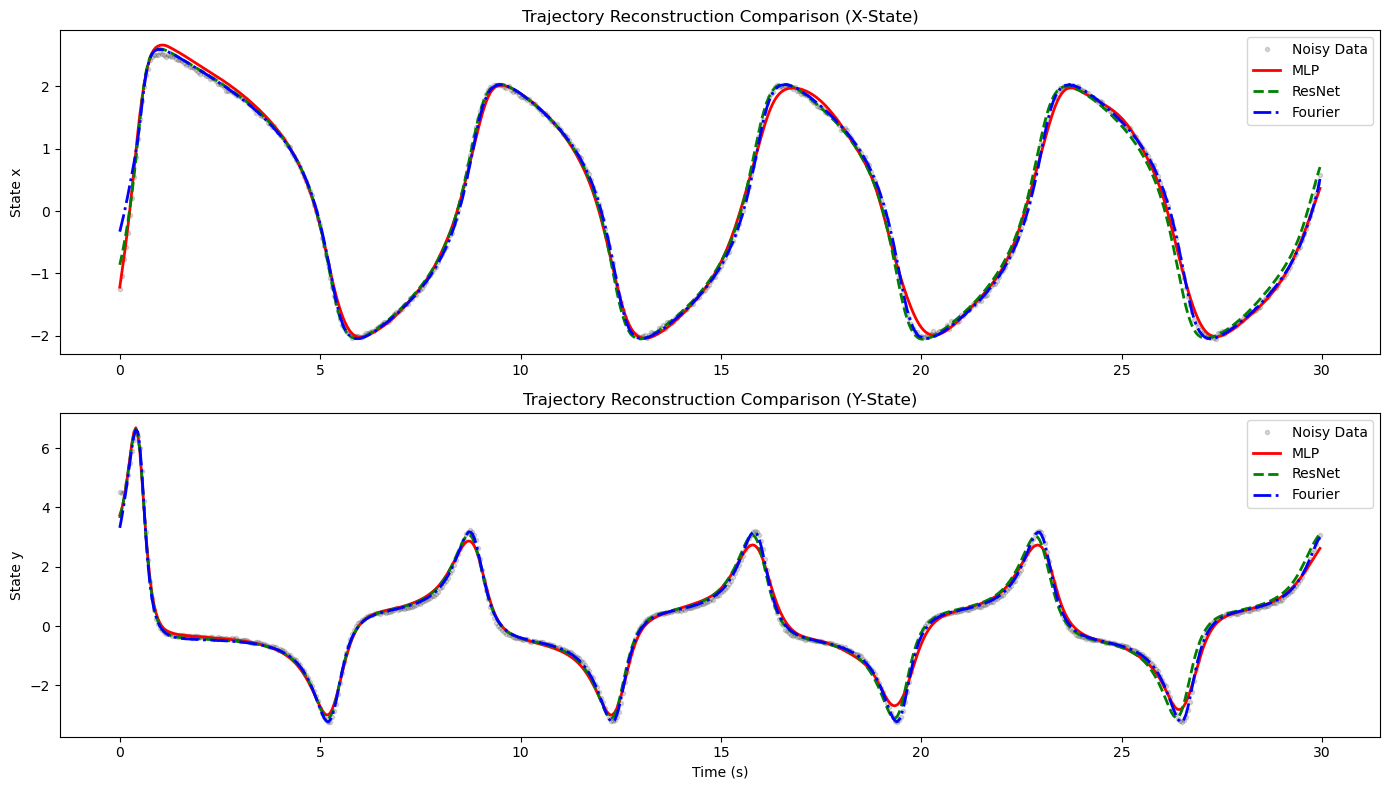

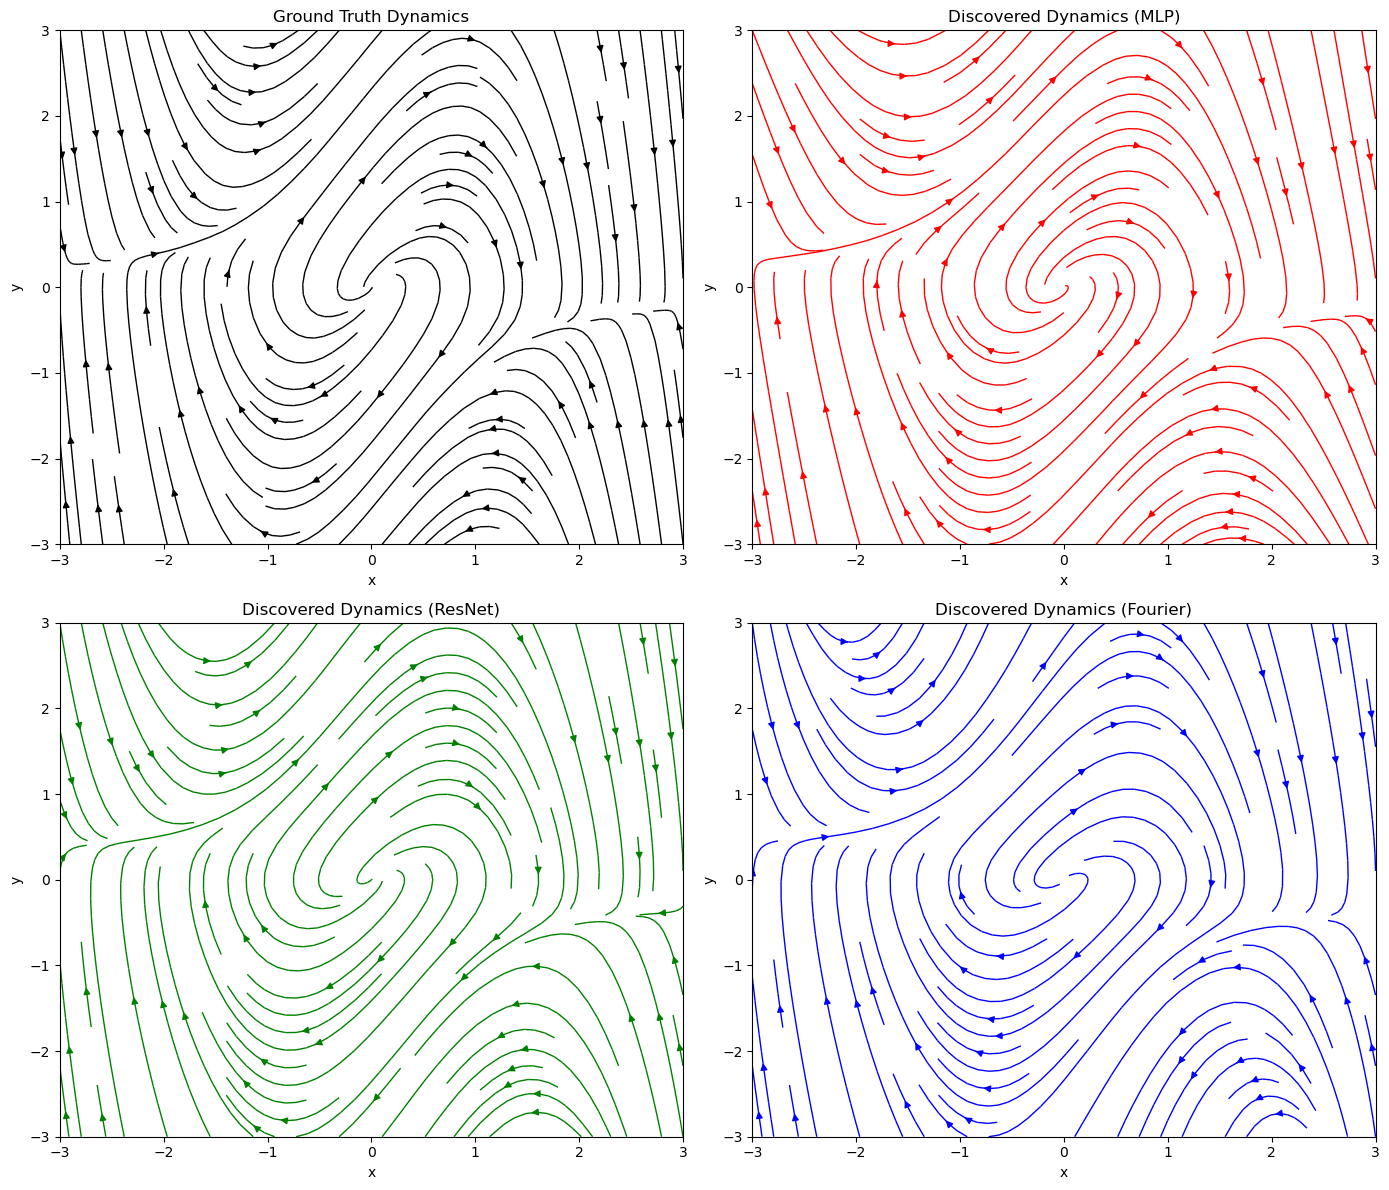

In [10]:
# ==========================================
# 5. Analysis & Visualization (Multi-Model)
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Setup Data for Plotting
# We assume train_t, train_u, and results are available from previous cells
t_plot = train_t.detach().cpu().numpy()
u_plot = train_u.detach().cpu().numpy()

# ------------------------------------------
# A. Print Discovered Equations
# ------------------------------------------
terms = ["1", "x", "y", "x^2", "xy", "y^2", "x^3", "x^2y", "xy^2", "y^3"]
print(f"\n{'='*20} DISCOVERED EQUATIONS COMPARISON {'='*20}")
print(f"Target x: dx/dt = y")
print(f"Target y: dy/dt = -x + 1.5y - 1.5x^2y")
print("-" * 60)

for name, res in results.items():
    model = res['model']
    coeffs = model.coeffs.detach().cpu().numpy()
    
    print(f"--- {name} ---")
    row_names = ["dx/dt", "dy/dt"]
    for i in range(2):
        eq_str = f"{row_names[i]} = "
        for j, term in enumerate(terms):
            val = coeffs[i, j]
            if abs(val) > 0.05: # Threshold to hide noise
                eq_str += f"{val:+.3f}*{term} "
        print(eq_str)
    print()

# ------------------------------------------
# B. Visualize Trajectories (Overlaid)
# ------------------------------------------
plt.figure(figsize=(14, 8))

# Define colors/styles for distinction
colors = {'MLP': 'r', 'ResNet': 'g', 'Fourier': 'b'}
styles = {'MLP': '-', 'ResNet': '--', 'Fourier': '-.'}

# Subplot 1: X-State
plt.subplot(2, 1, 1)
plt.plot(t_plot, u_plot[:, 0], 'k.', alpha=0.15, label="Noisy Data")

for name, res in results.items():
    model = res['model']
    model.eval()
    with torch.no_grad():
        u_pred = model(train_t).detach().cpu().numpy()
    
    plt.plot(t_plot, u_pred[:, 0], color=colors.get(name, 'C0'), 
             linestyle=styles.get(name, '-'), linewidth=2, label=f"{name}")

plt.ylabel("State x")
plt.title("Trajectory Reconstruction Comparison (X-State)")
plt.legend(loc="upper right")

# Subplot 2: Y-State
plt.subplot(2, 1, 2)
plt.plot(t_plot, u_plot[:, 1], 'k.', alpha=0.15, label="Noisy Data")

for name, res in results.items():
    model = res['model']
    with torch.no_grad():
        u_pred = model(train_t).detach().cpu().numpy()
    
    plt.plot(t_plot, u_pred[:, 1], color=colors.get(name, 'C0'), 
             linestyle=styles.get(name, '-'), linewidth=2, label=f"{name}")

plt.ylabel("State y")
plt.xlabel("Time (s)")
plt.title("Trajectory Reconstruction Comparison (Y-State)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ------------------------------------------
# C. Visualize Vector Fields (2x2 Grid)
# ------------------------------------------
# Create Grid
y_grid, x_grid = np.mgrid[-3.0:3.0:15j, -3.0:3.0:15j]
grid_points = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)

# True Flow
def get_vdp_flow(x, y, mu=1.5):
    return y, mu * (1 - x**2) * y - x
U_true, V_true = get_vdp_flow(x_grid, y_grid)

# Prepare Plot Grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Plot 1: Ground Truth
axes[0].streamplot(x_grid, y_grid, U_true, V_true, color='k', density=1.0, linewidth=1)
axes[0].set_title("Ground Truth Dynamics")
axes[0].set_xlabel('x'); axes[0].set_ylabel('y')

# Plot Models (MLP, ResNet, Fourier)
model_names = list(results.keys())
for i, name in enumerate(model_names):
    if i >= 3: break # Safety if >3 models
    
    ax = axes[i+1] # Fill slots 1, 2, 3
    model = results[name]['model']
    
    # Compute Flow on device
    device_used = next(model.parameters()).device
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device_used)
    
    with torch.no_grad():
        lib_features = model.build_library(grid_tensor)
        pred_flow = torch.matmul(lib_features, model.coeffs.t()).detach().cpu().numpy()
    
    U_pred = pred_flow[:, 0].reshape(x_grid.shape)
    V_pred = pred_flow[:, 1].reshape(y_grid.shape)
    
    ax.streamplot(x_grid, y_grid, U_pred, V_pred, color=colors.get(name, 'r'), density=1.0, linewidth=1)
    ax.set_title(f"Discovered Dynamics ({name})")
    ax.set_xlabel('x'); ax.set_ylabel('y')

plt.tight_layout()
plt.show()

In [11]:
# ==========================================
# 1. Enhanced Base Class (Neuro-Symbolic Library)
# ==========================================
class BasePINN(nn.Module):
    def __init__(self):
        super().__init__()
        # Library Terms:
        # Polynomials: [1, x, y, x^2, xy, y^2, x^3, x^2y, xy^2, y^3] (10 terms)
        # Neuro Terms: [tanh(x), tanh(y)] (2 terms)
        # Total Dim = 12
        self.library_dim = 10  # Change to 12 if Neuro Terms are added
        self.coeffs = nn.Parameter(torch.zeros(2, self.library_dim))
        nn.init.uniform_(self.coeffs, -0.1, 0.1)

    def build_library(self, u):
        """
        Updated Library based on Neuro-Dynamics priors.
        Includes Polynomials AND Sigmoidal terms (common in Neural Mass Models).
        """
        x = u[:, 0:1]
        y = u[:, 1:2]
        ones = torch.ones_like(x)
        
        # 1. Polynomials (Standard Volterra series)
        lib_poly = [ones, x, y, x**2, x*y, y**2, x**3, (x**2)*y, x*(y**2), y**3]
        
        # 2. Neuro Terms (Wilson-Cowan style firing rates)
        # We assume a slope of 1 for simplicity, though this could be learnable
        #lib_neuro = [torch.tanh(x), torch.tanh(y)]
        
        return torch.cat(lib_poly, dim=1) # or torch.cat(lib_poly + lib_neuro, dim=1)

    def compute_loss(self, t, u_noisy, threshold_mask=None):
        """
        Standard PINN Loss. 
        Args:
            threshold_mask: Optional binary mask to force zero coefficients (for STRidge).
        """
        if not t.requires_grad: t.requires_grad_(True)
        u_pred = self.forward(t)
        
        # Data Loss
        loss_data = torch.mean((u_pred - u_noisy)**2)
        
        # Physics Loss
        u_x = u_pred[:, 0:1]; u_y = u_pred[:, 1:2]
        grad_x = torch.autograd.grad(u_x, t, torch.ones_like(u_x), create_graph=True)[0]
        grad_y = torch.autograd.grad(u_y, t, torch.ones_like(u_y), create_graph=True)[0]
        u_dot_pred = torch.cat([grad_x, grad_y], dim=1)
        
        Theta = self.build_library(u_pred)
        
        # Apply mask if provided (Hard Thresholding support)
        effective_coeffs = self.coeffs
        if threshold_mask is not None:
            effective_coeffs = self.coeffs * threshold_mask
            
        rhs = torch.matmul(Theta, effective_coeffs.t())
        loss_physics = torch.mean((u_dot_pred - rhs)**2)
        
        # L1 Loss (Soft sparsity)
        loss_sparsity = 0.001 * torch.sum(torch.abs(effective_coeffs))
        
        return loss_data + loss_physics + loss_sparsity, loss_data, loss_physics

# ==========================================
# Architecture 1: Fourier Network (Best for Oscillations)
# ==========================================
class FourierEmbedding(nn.Module):
    def __init__(self, input_dim, hidden_dim, scale=5.0):
        super().__init__()
        self.B = nn.Parameter(torch.randn(input_dim, hidden_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        proj = 2 * np.pi * x @ self.B 
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

class PINN_Discovery_Fourier(BasePINN):
    def __init__(self, scale=2.0):
        super().__init__()
        self.net = nn.Sequential(
            FourierEmbedding(1, 64, scale=scale),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )
    def forward(self, t): return self.net(t)

# ==========================================
# Architecture 2: Bayesian PINN 
# ==========================================
class PINN_Discovery_Bayesian(BasePINN):
    def __init__(self, hidden_dim=64, dropout_rate=0.1):
        super().__init__()
        # We use Dropout layers which, active at training AND inference,
        # approximate a Bayesian Posterior (Gal & Ghahramani, 2016)
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim), nn.Tanh(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, t): return self.net(t)

# ==========================================
# Training: STRidge (Sequential Thresholding)
# ==========================================
# This implements the "PINN-SR" algorithm from the Nature Comms paper
def train_model_stridge(name, model, t_tensor, u_tensor, epochs=10000, lr=0.002):
    print(f"\nTraining {name} with STRidge (Iterative Hard Thresholding)...")
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # STRidge Params
    threshold = 0.1       # Coefficients below this are killed
    mask = torch.ones_like(model.coeffs).to(t_tensor.device)
    
    # We split training into phases:
    # Phase 1: Warmup (Standard L1)
    # Phase 2: Pruning (Hard Thresholding)
    
    history = []
    
    for epoch in range(epochs):
        # Every 1000 epochs, update the mask (Hard Threshold Step)
        if epoch > 1000 and epoch % 1000 == 0:
            with torch.no_grad():
                # Update mask: 1 if |coeff| > threshold, else 0
                current_coeffs = model.coeffs.detach()
                mask = (torch.abs(current_coeffs) > threshold).float()
                
                # Zero out coefficients immediately for stability
                model.coeffs.data.mul_(mask)
                print(f"  [Epoch {epoch}] STRidge Pruning... Active Terms: {torch.sum(mask).item()}")

        # Standard Step
        total_loss, l_data, l_phys = model.compute_loss(t_tensor, u_tensor, threshold_mask=mask)
        
        optimizer.zero_grad()
        total_loss.backward()
        
        # Enforce mask on gradients (prevent zeroed terms from learning back)
        if epoch > 1000:
             model.coeffs.grad.mul_(mask)
             
        optimizer.step()
        
        if epoch % 1000 == 0:
             history.append(total_loss.item())
             print(f"  Epoch {epoch}: Loss {total_loss.item():.5f}")

    return history

# ==========================================
# Execute
# ==========================================
models = {
    "Fourier (SR)": PINN_Discovery_Fourier(scale=2.0).to(device),
    "Bayesian (SR)": PINN_Discovery_Bayesian(dropout_rate=0.05).to(device)
}

results = {}
for name, model in models.items():
    hist = train_model_stridge(name, model, train_t, train_u)
    results[name] = {"model": model, "history": hist}


Training Fourier (SR) with STRidge (Iterative Hard Thresholding)...
  Epoch 0: Loss 4.20027
  Epoch 1000: Loss 0.03058
  [Epoch 2000] STRidge Pruning... Active Terms: 6.0
  Epoch 2000: Loss 0.20896
  [Epoch 3000] STRidge Pruning... Active Terms: 5.0
  Epoch 3000: Loss 3.07223
  [Epoch 4000] STRidge Pruning... Active Terms: 5.0
  Epoch 4000: Loss 0.00941
  [Epoch 5000] STRidge Pruning... Active Terms: 4.0
  Epoch 5000: Loss 0.05948
  [Epoch 6000] STRidge Pruning... Active Terms: 4.0
  Epoch 6000: Loss 0.00563
  [Epoch 7000] STRidge Pruning... Active Terms: 4.0
  Epoch 7000: Loss 0.00584
  [Epoch 8000] STRidge Pruning... Active Terms: 4.0
  Epoch 8000: Loss 0.00583
  [Epoch 9000] STRidge Pruning... Active Terms: 4.0
  Epoch 9000: Loss 0.00565

Training Bayesian (SR) with STRidge (Iterative Hard Thresholding)...
  Epoch 0: Loss 2.45305
  Epoch 1000: Loss 1.33640
  [Epoch 2000] STRidge Pruning... Active Terms: 3.0
  Epoch 2000: Loss 1.02316
  [Epoch 3000] STRidge Pruning... Active Terms: 

In [ ]:
# ==========================================
# 5. Analysis & Visualization (Neuro-Symbolic & Bayesian)
# ==========================================

# 1. Setup Data for Plotting
# We assume train_t, train_u, and results are available from previous cells
t_plot = train_t.detach().cpu().numpy()
u_plot = train_u.detach().cpu().numpy()

# ------------------------------------------
# A. Print Discovered Equations
# ------------------------------------------
# Updated terms list to match the Neuro-Symbolic library (12 terms)
terms = ["1", "x", "y", "x^2", "xy", "y^2", "x^3", "x^2y", "xy^2", "y^3", "tanh(x)", "tanh(y)"]

print(f"\n{'='*20} DISCOVERED EQUATIONS COMPARISON (SR-Trained) {'='*20}")
print(f"Target x: dx/dt = y")
print(f"Target y: dy/dt = -x + 1.5y - 1.5x^2y")
print("-" * 60)

for name, res in results.items():
    model = res['model']
    # Ensure model is on CPU for numpy conversion
    coeffs = model.coeffs.detach().cpu().numpy()
    
    print(f"--- {name} ---")
    row_names = ["dx/dt", "dy/dt"]
    for i in range(2):
        eq_str = f"{row_names[i]} = "
        for j, term in enumerate(terms):
            # Safety check
            if j >= coeffs.shape[1]: break
            
            val = coeffs[i, j]
            if abs(val) > 0.05: # Threshold to hide noise
                eq_str += f"{val:+.3f}*{term} "
        print(eq_str)
    print()

# ------------------------------------------
# B. Visualize Trajectories
# ------------------------------------------
plt.figure(figsize=(14, 8))

# Define colors/styles for the new models
colors = {'Fourier (SR)': 'purple', 'Bayesian (SR)': 'orange'}
styles = {'Fourier (SR)': '-', 'Bayesian (SR)': '--'}

# Subplot 1: X-State
plt.subplot(2, 1, 1)
plt.plot(t_plot, u_plot[:, 0], 'k.', alpha=0.15, label="Noisy Data")

for name, res in results.items():
    model = res['model']
    
    # Run in eval mode (Deterministic mean for Bayesian)
    model.eval() 
    with torch.no_grad():
        u_pred = model(train_t).detach().cpu().numpy()
    
    c = colors.get(name, 'C0')
    s = styles.get(name, '-')
    plt.plot(t_plot, u_pred[:, 0], color=c, linestyle=s, linewidth=2, label=f"{name}")

plt.ylabel("State x")
plt.title("Trajectory Reconstruction Comparison (X-State)")
plt.legend(loc="upper right")

# Subplot 2: Y-State
plt.subplot(2, 1, 2)
plt.plot(t_plot, u_plot[:, 1], 'k.', alpha=0.15, label="Noisy Data")

for name, res in results.items():
    model = res['model']
    with torch.no_grad():
        u_pred = model(train_t).detach().cpu().numpy()
    
    c = colors.get(name, 'C0')
    s = styles.get(name, '-')
    plt.plot(t_plot, u_pred[:, 1], color=c, linestyle=s, linewidth=2, label=f"{name}")

plt.ylabel("State y")
plt.xlabel("Time (s)")
plt.title("Trajectory Reconstruction Comparison (Y-State)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ------------------------------------------
# C. Visualize Vector Fields
# ------------------------------------------
y_grid, x_grid = np.mgrid[-3.0:3.0:15j, -3.0:3.0:15j]
grid_points = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)

# True Flow
def get_vdp_flow(x, y, mu=1.5):
    return y, mu * (1 - x**2) * y - x
U_true, V_true = get_vdp_flow(x_grid, y_grid)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Plot 1: Ground Truth
axes[0].streamplot(x_grid, y_grid, U_true, V_true, color='k', density=1.0, linewidth=1)
axes[0].set_title("Ground Truth Dynamics")
axes[0].set_xlabel('x'); axes[0].set_ylabel('y')

model_names = list(results.keys())
for i, name in enumerate(model_names):
    if i >= 3: break 
    
    ax = axes[i+1]
    model = results[name]['model']
    
    device_used = next(model.parameters()).device
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device_used)
    
    with torch.no_grad():
        # build_library now includes the Neuro terms automatically
        lib_features = model.build_library(grid_tensor)
        pred_flow = torch.matmul(lib_features, model.coeffs.t()).detach().cpu().numpy()
    
    U_pred = pred_flow[:, 0].reshape(x_grid.shape)
    V_pred = pred_flow[:, 1].reshape(y_grid.shape)
    
    c = colors.get(name, 'r')
    ax.streamplot(x_grid, y_grid, U_pred, V_pred, color=c, density=1.0, linewidth=1)
    ax.set_title(f"Discovered Dynamics ({name})")
    ax.set_xlabel('x'); ax.set_ylabel('y')

plt.tight_layout()
plt.show()

In [13]:
from torchdiffeq import odeint as torch_odeint

class VdP_NeuralODE(nn.Module):
    def __init__(self):
        super().__init__()
        # This network approximates dx/dt = f(x)
        # It takes state (2,) and outputs derivative (2,)
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
        
    def forward(self, t, y):
        # Neural ODEs expect forward(t, y) signature
        return self.net(y)

# --------------------------
# Training Loop Logic
# --------------------------
def train_neural_ode(model, batch_y0, batch_t, batch_y_true):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # 1. Forward: Integrate the network dynamics
    # This solves the ODE defined by model.net from t[0] to t[end]
    # Output shape: (Time, Batch, Dim)
    pred_y = torch_odeint(model, batch_y0, batch_t, method='dopri5')
    
    # 2. Loss: Compare integrated trajectory to data
    loss = torch.mean((pred_y - batch_y_true)**2)
    
    # 3. Backward: Adjoint method handles this automatically
    loss.backward()
    optimizer.step()
    return loss

In [14]:
# ==========================================
#  Training Setup & Execution (Neural ODE)
# ==========================================

# 1. Prepare Training Data
# Select the first trajectory for training, matching your reference
# NODE requires specific shapes:
# t: 1D tensor (T,)
# y: (T, Batch, Dim) or (T, Dim). We use (T, 1, 2) to treat it as batch_size=1
train_t = torch.tensor(t_eval, dtype=torch.float32).to(device)
print(f"Using device: {device}")
train_y = torch.tensor(noisy_trajs[0], dtype=torch.float32).unsqueeze(1).to(device) # Shape: (600, 1, 2)

print(f"Training Data Shapes: t={train_t.shape}, y={train_y.shape}")

# 2. Instantiate Models
# We put it in a dict to match your reference structure
models = {
    "NODE": VdP_NeuralODE().to(device)
}

# Store results
results = {}

# 3. Define Training Function
def train_node_model(name, model, t_tensor, y_tensor, epochs=2000, lr=0.01):
    print(f"\n{'='*40}")
    print(f"Training Architecture: {name}")
    print(f"{'='*40}")
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = []
    start_time = time.time()
    
    # Initial condition is the first data point
    # y0 shape: (1, 2) -> Batch size 1, Dimension 2
    y0 = y_tensor[0, :, :] 
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # 1. Forward: Integrate from t[0] to t[end]
        # output shape: (Time, Batch, Dim) -> (600, 1, 2)
        pred_y = torch_odeint(model, y0, t_tensor, method='rk4')
        
        # 2. Loss: MSE between predicted trajectory and data
        loss = torch.mean((pred_y - y_tensor)**2)
        
        # 3. Backward
        loss.backward()
        optimizer.step()
        
        # Logging
        if epoch % 100 == 0:
            print(f"Epoch {epoch:5d}: Loss={loss.item():.5f}")
            history.append(loss.item())
            
    elapsed = time.time() - start_time
    print(f"--> Finished {name} in {elapsed:.1f}s. Final Loss: {loss.item():.5f}")
    return history

# 4. Execute Training Loop
for name, model in models.items():
    loss_history = train_node_model(name, model, train_t, train_y)
    results[name] = {
        "model": model,
        "history": loss_history
    }

Training Data Shapes: t=torch.Size([600]), y=torch.Size([600, 1, 2])

Training Architecture: NODE
Epoch     0: Loss=81.10064
Epoch   100: Loss=2.09827
Epoch   200: Loss=1.93509
Epoch   300: Loss=1.87799
Epoch   400: Loss=1.82285
Epoch   500: Loss=2.02626
Epoch   600: Loss=1.91936
Epoch   700: Loss=2.43458
Epoch   800: Loss=2.15532
Epoch   900: Loss=1.65067
Epoch  1000: Loss=1.58256
Epoch  1100: Loss=2.00875
Epoch  1200: Loss=1.81798
Epoch  1300: Loss=1.72395
Epoch  1400: Loss=2.12619
Epoch  1500: Loss=2.10375
Epoch  1600: Loss=2.08778
Epoch  1700: Loss=2.07671
Epoch  1800: Loss=2.06855
Epoch  1900: Loss=2.06075
--> Finished NODE in 552.6s. Final Loss: 2.05011



==================== MODEL PERFORMANCE SUMMARY ====================
Model: NODE
Final Training MSE: 2.06075e+00
------------------------------------------------------------


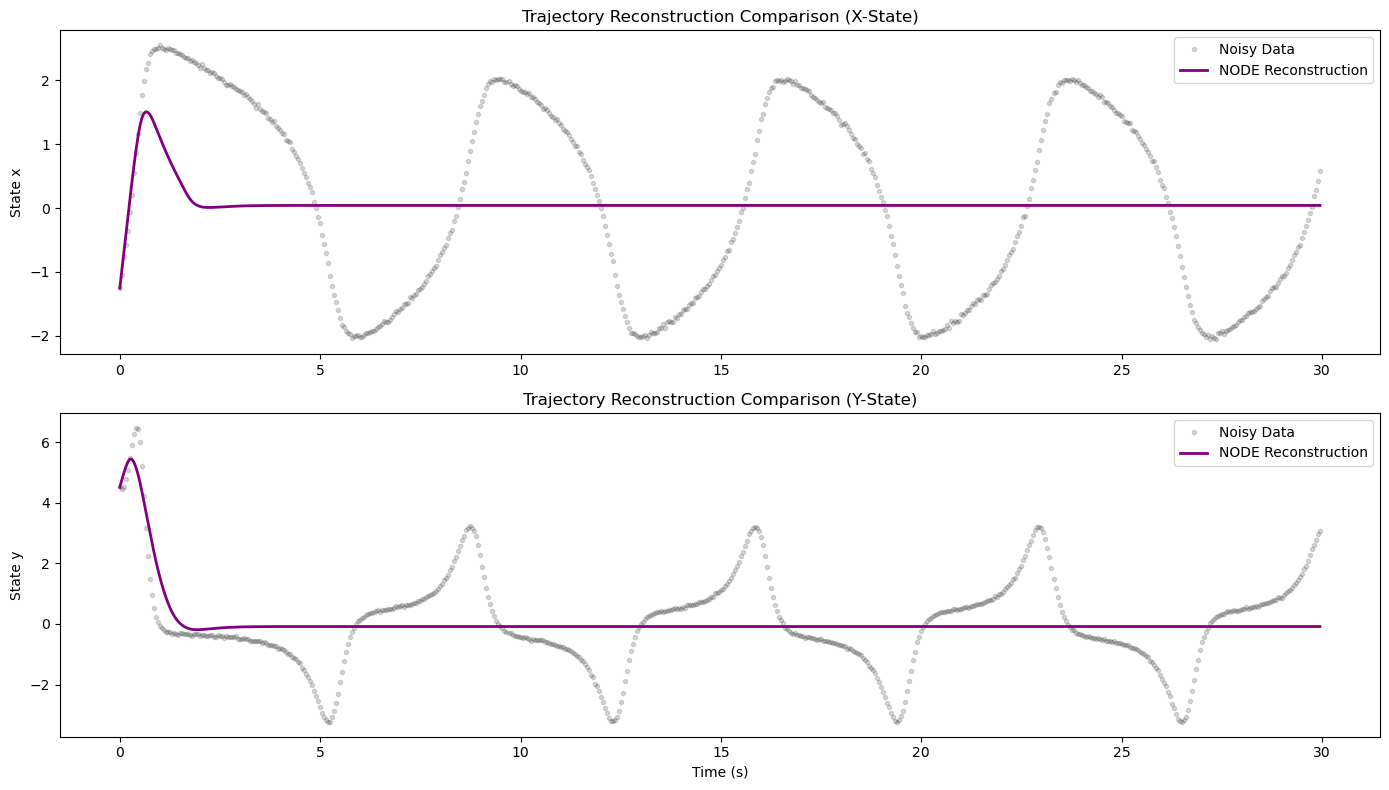

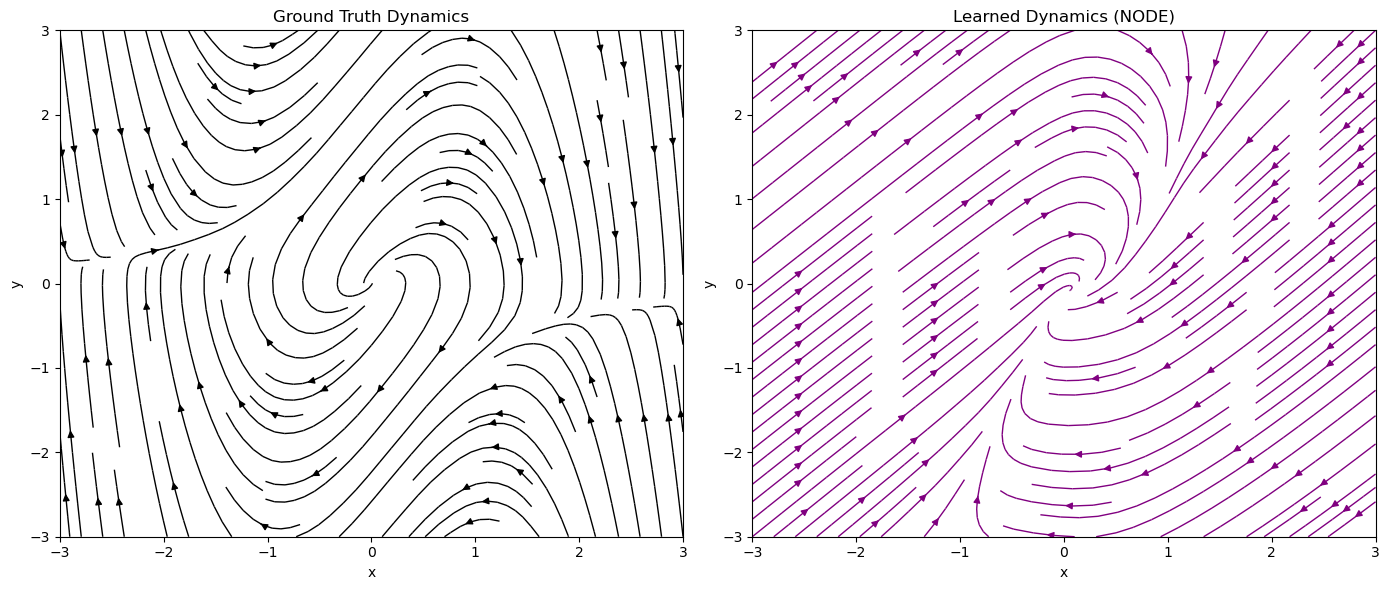

In [16]:
# ==========================================
# Analysis & Visualization (Neural ODE)
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Setup Data for Plotting
# We assume train_t, train_y (from previous cell) are tensors on device
# Convert back to numpy for plotting
t_plot = train_t.detach().cpu().numpy()
u_plot = train_y.squeeze(1).detach().cpu().numpy() # Remove batch dim: (T, 1, 2) -> (T, 2)

# ------------------------------------------
# A. Model Performance Summary
# ------------------------------------------
print(f"\n{'='*20} MODEL PERFORMANCE SUMMARY {'='*20}")
for name, res in results.items():
    history = res['history']
    final_loss = history[-1] if len(history) > 0 else 0
    print(f"Model: {name}")
    print(f"Final Training MSE: {final_loss:.5e}")
print("-" * 60)

# ------------------------------------------
# B. Visualize Trajectories (Integration)
# ------------------------------------------
plt.figure(figsize=(14, 8))

# Define colors/styles
colors = {'NODE': 'purple'} 
styles = {'NODE': '-'}

# Subplot 1: X-State
plt.subplot(2, 1, 1)
plt.plot(t_plot, u_plot[:, 0], 'k.', alpha=0.15, label="Noisy Data")

for name, res in results.items():
    model = res['model']
    model.eval()
    
    # For Neural ODE, we must INTEGRATE to get the trajectory
    # Start from the true initial condition of the data
    y0 = train_y[0, :, :] # Shape (1, 2)
    
    with torch.no_grad():
        # Integrate forward in time
        pred_y = torch_odeint(model, y0, train_t, method='rk4')
        # pred_y shape: (Time, Batch, Dim) -> (T, 1, 2)
        u_pred = pred_y.squeeze(1).cpu().numpy()
    
    plt.plot(t_plot, u_pred[:, 0], color=colors.get(name, 'C0'), 
             linestyle=styles.get(name, '-'), linewidth=2, label=f"{name} Reconstruction")

plt.ylabel("State x")
plt.title("Trajectory Reconstruction Comparison (X-State)")
plt.legend(loc="upper right")

# Subplot 2: Y-State
plt.subplot(2, 1, 2)
plt.plot(t_plot, u_plot[:, 1], 'k.', alpha=0.15, label="Noisy Data")

for name, res in results.items():
    # We already computed u_pred in the loop above, but re-accessing for clarity
    # (In a real script, compute once and store)
    model = res['model']
    y0 = train_y[0, :, :]
    with torch.no_grad():
        pred_y = torch_odeint(model, y0, train_t, method='rk4')
        u_pred = pred_y.squeeze(1).cpu().numpy()

    plt.plot(t_plot, u_pred[:, 1], color=colors.get(name, 'C0'), 
             linestyle=styles.get(name, '-'), linewidth=2, label=f"{name} Reconstruction")

plt.ylabel("State y")
plt.xlabel("Time (s)")
plt.title("Trajectory Reconstruction Comparison (Y-State)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ------------------------------------------
# C. Visualize Vector Fields (Comparison)
# ------------------------------------------
# Create Grid
y_grid, x_grid = np.mgrid[-3.0:3.0:15j, -3.0:3.0:15j]
# Stack for model input: (N_points, 2)
grid_points = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)

# 1. True Flow (Analytical)
def get_vdp_flow(x, y, mu=1.5):
    return y, mu * (1 - x**2) * y - x

U_true, V_true = get_vdp_flow(x_grid, y_grid)

# 2. Predicted Flow (Neural Network)
# We take the first model from results
name = "NODE"
model = results[name]['model']

device_used = next(model.parameters()).device
grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device_used)

with torch.no_grad():
    # The NODE model predicts the derivative (dy/dt) given state y
    # forward(t, y) -> we pass t=0 (autonomous system)
    pred_flow = model(torch.tensor(0.0), grid_tensor).detach().cpu().numpy()

U_pred = pred_flow[:, 0].reshape(x_grid.shape)
V_pred = pred_flow[:, 1].reshape(y_grid.shape)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Ground Truth
st1 = axes[0].streamplot(x_grid, y_grid, U_true, V_true, color='k', density=1.0, linewidth=1)
axes[0].set_title("Ground Truth Dynamics")
axes[0].set_xlabel('x'); axes[0].set_ylabel('y')
axes[0].set_xlim(-3, 3); axes[0].set_ylim(-3, 3)

# Plot 2: Neural ODE Learned Dynamics
st2 = axes[1].streamplot(x_grid, y_grid, U_pred, V_pred, color='purple', density=1.0, linewidth=1)
axes[1].set_title(f"Learned Dynamics ({name})")
axes[1].set_xlabel('x'); axes[1].set_ylabel('y')
axes[1].set_xlim(-3, 3); axes[1].set_ylim(-3, 3)

plt.tight_layout()
plt.show()